# Amazon Fine Food Reviews Analysis
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews 

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

Id
ProductId - unique identifier for the product
UserId - unqiue identifier for the user
ProfileName
HelpfulnessNumerator - number of users who found the review helpful
HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
Score - rating between 1 and 5
Time - timestamp for the review
Summary - brief summary of the review
Text - text of the review

## Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## Loading the data
The dataset is available in two forms

.csv file
SQLite Database
In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. 
Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from nltk.stem.porter import PorterStemmer

import re#regularexpressions
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


In [2]:
d=pd.read_csv("Reviews.csv")
print(d.shape)
con=sqlite3.connect('database.sqlite 2')

filtered_data=pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score!=3
LIMIT 5000""", con)

def partition(x):
    if x<3:
        return 'negative'
    return 'positive'

actualScore=filtered_data['Score']
positivenegative=actualScore.map(partition)
filtered_data['Score']=positivenegative
print("number of data points in our data are", filtered_data.shape)
filtered_data.head(2)

(568454, 10)
number of data points in our data are (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [3]:
print(filtered_data.columns)

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [4]:
display=pd.read_sql_query("""SELECT ProductId, UserId, ProfileName, Score, Time,COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>4
""", con)

In [5]:
print(display.shape)#THIS IS THE REPEATED DATA IN 

(23593, 6)


In [6]:
display.head(2)

,ProductId,UserId,ProfileName,Score,Time,COUNT(*)
0,B005DGI1PW,A1001WMV1CL0XH,Corey DePaul,5,1345334400,6
1,B001RV8CGK,A10023OS6MZUC6,Wilton Dubois,2,1274313600,5


In [7]:
display['COUNT(*)'].sum()

243907

# Data Cleaning

### [2] Data cleaning: de duplication
- in the give dataset from kaggle.com i noticed that their is lots of data which is repeting in this dataset. So, here i clean the data to make the data more obserbable for every person who is going to read this data. Hence it is necessary to remove the dulicates.

In [8]:
display=pd.read_sql_query("""
SELECT * FROM Reviews
WHERE Score!=3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductId""",con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


- IN THE ABOVE OUTPUT WE CAN SEE THAT THEIR IS A 5 COMMENT AT THE SAME TIME BY A SAME USER. THIS IS WHAT WE CALLED DUPLICATES

In [9]:
sorted_data=filtered_data.sort_values('Id', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
sorted_data.head(5)   
# na_position=first puts NaNs at the beginning, last puts NaNs="not a numbers" at the end


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
4999,5427,B00622CYVS,A3EPC08TVAPA0N,Krissia,0,3,negative,1340582400,Waste of time.,My baby loves this food. At whole foods they ...
4998,5426,B00622CYVS,A2NYT3UXUTBY23,C&GHoll,1,3,negative,1249603200,Wrong item shipped,We ordered the Earth's best 2nd dinner variety...
4997,5425,B00622CYVS,A2YHXAZLCLDT8D,"Mark Smith ""Food lover""",0,1,positive,1236988800,Dinner time is Earths Best TIme !!,My little guy loves to try new foods..so this ...
4996,5424,B00622CYVS,A32DHN8U74GCAR,"Granola Girl ""michele j.""",0,1,positive,1240790400,Food Delivery,This is great! Organic baby food options - de...
4995,5423,B00622CYVS,A17ASMX6QMO6XY,E. Harvill,0,1,negative,1277424000,Not so tasty...,"My baby didn't seem into these dinners, so I t..."


### HERE WE ARE REMOVING THOSE DATA WHICH IS DUPLICATE

In [10]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)#inplace=Whether to drop duplicates in place or to return a copy
final.shape

(4986, 10)

In [11]:
(final.size)/(filtered_data.size)*100

99.72

<b>Point to Remember:- </b> It was also seen that the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible.

In [12]:
display=pd.read_sql_query("""
SELECT * FROM Reviews WHERE HelpfulnessNumerator>HelpfulnessDenominator
ORDER BY ProductId""",con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


- Hence these two rows too are removed from calcualtions

In [13]:
final.shape

(4986, 10)

In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
print(final.shape)

(4986, 10)


In [16]:
final['Score'].value_counts()

positive    4178
negative     808
Name: Score, dtype: int64

# THIS IS HOW WE GET ANY RANDOM VALUE FROM THE DATASET

In [17]:
review_0=final['Text'].values[0]
print(review_0) 

My baby loves this food.  At whole foods they sell the same flat for 10.99 and thats retail.  I ordered this and just received it today.  I hadn't even opened package and I could smell a rotten smell coming from box. I opened it to find jar smashed and mold everywhere! I'm so disgusted and can't believe I waited over a week for this to arrive.  What a waste of my time.  The worst part is I ordered the fruit flat as well and also a broken jar and rotten mold everywhere.  I don't get how this happens the  shipping box isn't dented or damaged neither is the flat box.  So what someone packaged and sent a smashed and rotting shipment? Not a happy customer!


In [18]:
review_1000=final['Text'].values[69]
print(review_1000) 

This gum is delicious and since my first pack I have been hooked.  I love the Mint Chocolate Chip after meals, and the Key Lime Pie is delectable at all other times.<br /><br />At $15/10 pack on Amazon, it's not really a deal, though, considering this is only a $1 a pack at target or mcwallymart.  Once the price of a 10-pack drops to about $10 or $11 I might consider buying it online if only out of pure laziness, but a 50% premium is not really worth it.


###### THIS IS HOW WE REMOVE URLS FROM TEXT IN PYTHON

In [19]:
review_1000=re.sub(r"http\S+","",review_1000)
print(review_1000)

This gum is delicious and since my first pack I have been hooked.  I love the Mint Chocolate Chip after meals, and the Key Lime Pie is delectable at all other times.<br /><br />At $15/10 pack on Amazon, it's not really a deal, though, considering this is only a $1 a pack at target or mcwallymart.  Once the price of a 10-pack drops to about $10 or $11 I might consider buying it online if only out of pure laziness, but a 50% premium is not really worth it.


#### FOR REMOVING ALL THE TAG ELEMENTS FROM SUMMARY WE USE <u>BeautifulSoup</u> from <u>bs4</u>

In [20]:
from bs4 import BeautifulSoup
soup=BeautifulSoup(review_1000, 'lxml')
text=soup.get_text()
print(text)

This gum is delicious and since my first pack I have been hooked.  I love the Mint Chocolate Chip after meals, and the Key Lime Pie is delectable at all other times.At $15/10 pack on Amazon, it's not really a deal, though, considering this is only a $1 a pack at target or mcwallymart.  Once the price of a 10-pack drops to about $10 or $11 I might consider buying it online if only out of pure laziness, but a 50% premium is not really worth it.


- HERE AS WE CAN SEE THAT THE TAGS ARE REMOVED NOW IN THE ABOVE OUTPUT

In [21]:
import re#regular expression

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [22]:
review_1000=decontracted(review_1000)
print(review_1000)

This gum is delicious and since my first pack I have been hooked.  I love the Mint Chocolate Chip after meals, and the Key Lime Pie is delectable at all other times.<br /><br />At $15/10 pack on Amazon, it is not really a deal, though, considering this is only a $1 a pack at target or mcwallymart.  Once the price of a 10-pack drops to about $10 or $11 I might consider buying it online if only out of pure laziness, but a 50% premium is not really worth it.


- the above output consist of too many numerical values. so lets remove them by using .sub function from 're' module

In [23]:
#THIS IS HOW WE CAN REMOVE WORDS WITH NUMBERS.
review_1000=re.sub("\S*\d\S*","",review_1000).strip()
print(review_1000)

This gum is delicious and since my first pack I have been hooked.  I love the Mint Chocolate Chip after meals, and the Key Lime Pie is delectable at all other times.<br /><br />At  pack on Amazon, it is not really a deal, though, considering this is only a  a pack at target or mcwallymart.  Once the price of a  drops to about  or  I might consider buying it online if only out of pure laziness, but a  premium is not really worth it.


In [24]:
#removal of special characters
review_1000=re.sub('[^A-Za-z0-9]*', ' ',review_1000)
print(review_1000)

 T h i s  g u m  i s  d e l i c i o u s  a n d  s i n c e  m y  f i r s t  p a c k  I  h a v e  b e e n  h o o k e d  I  l o v e  t h e  M i n t  C h o c o l a t e  C h i p  a f t e r  m e a l s  a n d  t h e  K e y  L i m e  P i e  i s  d e l e c t a b l e  a t  a l l  o t h e r  t i m e s  b r  b r  A t  p a c k  o n  A m a z o n  i t  i s  n o t  r e a l l y  a  d e a l  t h o u g h  c o n s i d e r i n g  t h i s  i s  o n l y  a  a  p a c k  a t  t a r g e t  o r  m c w a l l y m a r t  O n c e  t h e  p r i c e  o f  a  d r o p s  t o  a b o u t  o r  I  m i g h t  c o n s i d e r  b u y i n g  i t  o n l i n e  i f  o n l y  o u t  o f  p u r e  l a z i n e s s  b u t  a  p r e m i u m  i s  n o t  r e a l l y  w o r t h  i t  


In [25]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [26]:
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
 
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    
    

100%|██████████| 4986/4986 [00:02<00:00, 2109.85it/s]


In [27]:
print(preprocessed_reviews[100])

picked package airport layover since not back lax soon decided check amazon oz package cost airport get small price break buying triple packs wow flavor amazing not know reviewer got bad batch mine crunchy walnuts smoothest slightly sweet tasting thick dark chocolate coating one bite hooked looking sweet treat sweetie look no every adult easter basket christmas stocking not raved candy like since see dark chocolate covered raspberry cremes like walnuts dark chocolate absolutely love taste pleasurable hard describe ordered packages use gifts amazon need start selling use prime shipping fly shelf promise ingredients organic walnuts organic ark chocolate coating ooh organic chocolate liquour soy lethicin tasty smooth contains small amounts milk soy wheat egg manufactured plant processes peanuts made usa tropical valley foods yes melt hand hot sun forewarned


- everything written inside above [ ] are just like as the index number 

# BAG OF WORDS

In [28]:
count_vect=CountVectorizer() #this is present in scikit learn 
count_vect.fit(preprocessed_reviews)
print("some features names",count_vect.get_feature_names()[0:5])
print("="*50)
final_counts=count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer is ",type(final_counts))
print("the shape of text BOW vectorizer is ",final_counts.get_shape())
print("the number of unique words are ",final_counts.get_shape()[1])

some features names ['aa', 'aahhhs', 'aback', 'abandon', 'abates']
the type of count vectorizer is  <class 'scipy.sparse.csr.csr_matrix'>
the shape of text BOW vectorizer is  (4986, 12997)
the number of unique words are  12997


- <b>OBSERVATION:</b> in the above code we are using .get_shape in place of .shape()
otherwise it will show an error as tuple objects are not callable

## OBJECTIVE OF TSNE

BY PLOTTING THE TSNE WE LEARN THAT HOW WE HAVE TO REDUCE THE DIMENSIONS OF DATA WHICH HELPS THE READER IN UNDERSTANDING THE HIGH DIMENSIONAL DATA INTO 2D OR 3D

# TSNE ON BAG OF WORDS

shape of tsne reduced data= (4986, 12997)


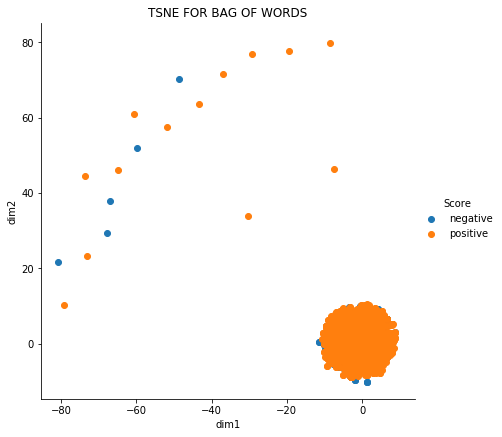

In [29]:
from sklearn.manifold import TSNE

tsne=final_counts[0:5000,:]

label_5000 = final['Score'][0:5000].values.reshape(-1, 1)  

model=TSNE(n_components=2,random_state=0)

print("shape of tsne reduced data=",tsne.shape)

model = TSNE(n_components=2, random_state=0, perplexity= 30, n_iter= 5000)

tsne_data = model.fit_transform(tsne.toarray())

tsne_data=np.hstack((tsne_data, label_5000))

tsne_df=pd.DataFrame(data=tsne_data,columns=('dim1','dim2','Score'))
tsne_data.shape
#plotting 
sns.FacetGrid(tsne_df,hue='Score', height=6).map(plt.scatter,'dim1','dim2').add_legend()
plt.title("TSNE FOR BAG OF WORDS")
plt.show()

## Bi-Grams and n-Grams

In [30]:
count_vect=CountVectorizer(ngram_range=(2,10), min_df=10,max_features=5000)
#min_df = 5 means "ignore terms that appear in less than 5 documents".
final_bigram_counts=count_vect.fit_transform(preprocessed_reviews)
print('the type of count_vectorizer is ',type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words from both bigram and unigram are ",final_bigram_counts.get_shape()[1])

the type of count_vectorizer is  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 977)
the number of unique words from both bigram and unigram are  977


- on increasing the x and y cordinates of ngram-range, number of unique words from both unigram and bigram are decreasing
As range increases time in output also increases

# TSNE ON BIGRAMS AND N-GRAMS

(4986, 3)


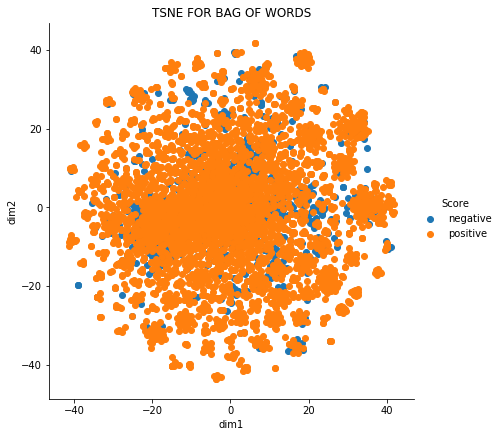

In [31]:
tsne=final_bigram_counts[0:5000,:]
label_5000=final['Score'][0:5000].values.reshape(-1,1)
model=TSNE(n_components=2,random_state=0,perplexity=80,n_iter=5000)
tsne_data=model.fit_transform(tsne.toarray())
#for new dataframe
tsne_data=np.hstack((tsne_data,label_5000))
tsne_df=pd.DataFrame(data=tsne_data,columns=('dim1','dim2','Score'))
print(tsne_data.shape)
#plotting of graph
sns.FacetGrid(tsne_df,hue='Score', height=6).map(plt.scatter,'dim1','dim2').add_legend()
plt.title("TSNE FOR BAG OF WORDS")
plt.show()

## TF-IDF

In [32]:
tf_idf_vect=TfidfVectorizer(ngram_range=(1,219),min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample of tf_idf are ",tf_idf_vect.get_feature_names()[0:10])
print("="*50)

final_tf_idf=tf_idf_vect.transform(preprocessed_reviews)
print("the type of the tfidf vector is ",type(final_tf_idf))
print("the shape of the tfidf vector is ",final_tf_idf.get_shape())
print("the number of unique words including both unigraram and bigram is ",final_tf_idf.get_shape()[1])

some sample of tf_idf are  ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of the tfidf vector is  <class 'scipy.sparse.csr.csr_matrix'>
the shape of the tfidf vector is  (4986, 3195)
the number of unique words including both unigraram and bigram is  3195


In [33]:
features=tf_idf_vect.get_feature_names()
len(features)
print(features[0:5])

['ability', 'able', 'able find', 'able get', 'absolute']


# TSNE ON TFIDF

(4986, 3)


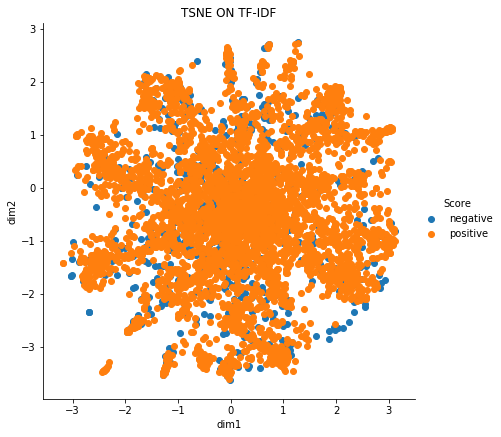

In [34]:
tsne=final_tf_idf[0:5000,:]
label_5000=final['Score'][0:5000].values.reshape(-1,1)
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
tsne_data=model.fit_transform(tsne.toarray())
#new dataframe
tsne_data=np.hstack((tsne_data,label_5000))
tsne_df=pd.DataFrame(data=tsne_data,columns=('dim1','dim2','Score'))
print(tsne_data.shape)
#printing plot
sns.FacetGrid(tsne_df,hue='Score',height=6).map(plt.scatter,'dim1','dim2').add_legend()
plt.title("TSNE ON TF-IDF")
plt.show()

# Word2vec

In [35]:
i=0
list_of_sentence=[]
for sentence in preprocessed_reviews:
    list_of_sentence.append(sentence.split())

In [36]:
w2v_model=Word2Vec(list_of_sentence,min_count=5,size=5000,workers=4)
print(w2v_model.wv.most_similar('great'))
print("="*66)
print(w2v_model.wv.most_similar('worst'))
print("="*66)
print(list_of_sentence[6])

[('alternative', 0.9999507665634155), ('calorie', 0.9999367594718933), ('regular', 0.9999309778213501), ('thai', 0.999928891658783), ('need', 0.9999264478683472), ('exactly', 0.9999250173568726), ('popchips', 0.9999243021011353), ('content', 0.999923825263977), ('quick', 0.999923586845398), ('surprisingly', 0.999923586845398)]
[('goes', 0.9999911785125732), ('together', 0.9999905824661255), ('wow', 0.9999899864196777), ('liquid', 0.9999896883964539), ('wife', 0.9999895691871643), ('experience', 0.9999895095825195), ('bars', 0.9999894499778748), ('house', 0.9999892711639404), ('filled', 0.9999890923500061), ('eaten', 0.9999889731407166)]
['son', 'really', 'enjoys', 'flavors', 'eats', 'fast', 'shipping', 'no', 'shopping', 'stores', 'great', 'prices', 'would', 'recommend']


In [37]:
w2v_words=list(w2v_model.wv.vocab)
print("no of words that occur minimum 5 times ",len(w2v_words))
print("saome words for sample",w2v_words[0:50])

no of words that occur minimum 5 times  3817
saome words for sample ['baby', 'loves', 'food', 'whole', 'foods', 'sell', 'flat', 'thats', 'retail', 'ordered', 'received', 'today', 'not', 'even', 'opened', 'package', 'could', 'smell', 'rotten', 'coming', 'box', 'find', 'jar', 'mold', 'everywhere', 'disgusted', 'believe', 'waited', 'week', 'arrive', 'waste', 'time', 'worst', 'part', 'fruit', 'well', 'also', 'broken', 'get', 'happens', 'shipping', 'dented', 'damaged', 'neither', 'someone', 'packaged', 'sent', 'shipment', 'happy', 'customer']


In [38]:
model=("man","woman","kislay")
w2v_model.wv.most_similar('woman')

[('wants', 0.9999505877494812),
 ('treat', 0.9999427199363708),
 ('enjoys', 0.9999419450759888),
 ('consider', 0.999941885471344),
 ('stay', 0.999941349029541),
 ('looking', 0.9999399185180664),
 ('certainly', 0.999939501285553),
 ('truly', 0.9999392628669739),
 ('friend', 0.9999375343322754),
 ('chew', 0.9999372959136963)]

# AVG_W2V

In [79]:
sent_vectors=[];
for sent in tqdm(list_of_sentence):
    sent_vec=np.zeros(5000)
    cnt_words=0;
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec+=vec
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:06<00:00, 718.12it/s]

4986
5000


# TSNE ON AVGW2V

In [95]:
avg_w2v=np.asmatrix(sent_vectors)
avg_w2v.shape

(4986, 5000)

In [104]:
label=final['Score']
print(label.shape)
model=TSNE(n_components=2,random_state=0,perplexity=99,n_iter=250)
tsne_data=model.fit_transform(avg_w2v)
print(tsne.shape)
tsne_data = np.vstack((tsne_data.T, labels)).T
print(tsne_data.shape)
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
print(tsne_df.shape)


(4986,)
(4986, 3195)
(4986, 3)
(4986, 3)


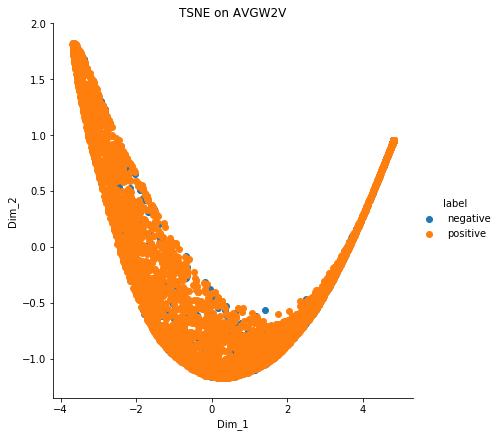

In [105]:
sns.FacetGrid(tsne_df,hue="label",height=6).map(plt.scatter,'Dim_1','Dim_2').add_legend()
plt.title("TSNE on AVGW2V")
plt.show()

# TFIDF WEIGHTED W2V

In [207]:
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence: # for each review/sentence
    sent_vec = np.zeros(5000) # as word vectors are of zero length
    #DIGIT IN NP.ZEROS WILL BE SAME AS THE NUMBER OF REVIEWS/LABELS WE ARE USING FOR DEFINING TSNE
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec=w2v_model.wv[word]
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
    if weight_sum!=0:
        sent_vec/=weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row +=1
        

# TSNE ON TFIDF W2V

In [208]:
label=final['Score']
print(label.shape)


(4986,)


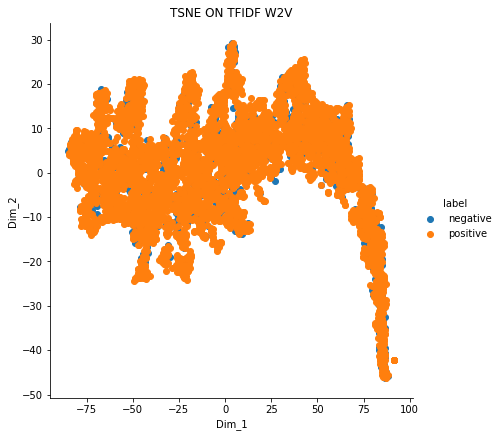

In [212]:
labels = final['Score']


model = TSNE(n_components=2, random_state=0, perplexity =88, n_iter = 5000)


tsne_data = model.fit_transform(tfidf_sent_vectors)



tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))



sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TSNE ON TFIDF W2V')
plt.show()

## CONCLUSION

1. ACCORDING TO MY POINT OF VIEW I AM NOT GETTING MUCH OBSERVATION FROM ALL THE TSNE'S THAT I PLOT BECAUSE ALL THE POSITIVE AND NEGATIVE POINTS ARE OVERLAPPING ON EACH OTHER.
2. TSNE ON BAG OF WORDS IS LITTLE HELPFUL BECAUSE FEW POINTS ARE NOT OVERLAPPING ON EACH OTHER BUT REST OF THEM ARE ALSO OVERLAPPING AS OTHER.
3. POSITIVE POINTS ARE OVERLAPPING ON THE NEGATIVE POINTS WHICH SIGNIFIES THAT SATISFIED CUSTOMERS ARE MORE THAN THE DISSATISFIED CUSTOMERS.
4. ALWAYS TRY TO PLOT THE TSNE WITH DIFFERENT PERPLEXITY VALUES SO THAT WE CAN GET FINE RESULTS.
5. N_ITER(NO OF ITERATION) COULD NOT BE MORE THAN THE ACTUAL LIMIT OF POINTS THAT WE ARE USING IN PLOTTING THE TSNE ON SPECIFIC DATA.
